# SHyTCWaves - Application for spectral reconstruction

In [1]:
import os
import os.path as op
import time

import numpy as np
import xarray as xr
from bluemath_tk.tcs.shytcwaves import historic2shytcwaves_cluster
from bluemath_tk.tcs.tracks import check_and_plot_track_data, resample_storm_6h

* Data access can be requested to bluemath@unican.es
You can update any path or add new paths with the update_paths function, from bluemath_tk.config.paths.
Example: update_paths({'SHYTCWAVES_COEFS': '/new/path/to/data'})


## 1. Load data

In [2]:
# IBTrACS
p_tracks = "https://geoocean.sci.unican.es/thredds/dodsC/geoceanData/GEOOCEAN/IBTrACS.ALL.v04r00.nc"
xds_tcs = xr.open_dataset(p_tracks)
xds_tcs

<xarray.Dataset> Size: 8GB
Dimensions:           (storm: 13557, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] 39MB ...
    lat               (storm, date_time) float32 20MB ...
    lon               (storm, date_time) float32 20MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 54kB ...
    sid               (storm) |S64 868kB ...
    season            (storm) float32 54kB ...
    number            (storm) int16 27kB ...
    basin             (storm, date_time) |S64 312MB ...
    subbasin          (storm, date_time) |S64 312MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 20MB ...
    reunion_gust_per  (storm, date_time) float32 20MB ...
    usa_seahgt        (storm, date_time) float32 20MB ...
    usa_searad        (storm, date_time, quadrant) float32 78MB ...
    storm_speed       (storm, date_time) float32 20MB ...
    storm_dir         (storm, date_time) float32 20MB ...
Attributes: (12/52)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3
    DODS.strlen:                2
    DODS.dimName:               char2

In [3]:
output_folder_name = "outputs"
output_path = op.join(os.getcwd(), output_folder_name)
os.makedirs(output_path, exist_ok=True)

## 2. Storm selection

In [4]:
# to select tc from name and year
name_tc, year_tc = "KATRINA", 2005
itc = np.where(
    (xds_tcs["name"].values.astype("str") == name_tc)
    & (xds_tcs.isel(date_time=0).time.dt.year.values == year_tc)
)[0]
storm = xds_tcs.isel(storm=itc).squeeze().load()
storm

<xarray.Dataset> Size: 556kB
Dimensions:           (date_time: 360, quadrant: 4)
Coordinates:
    time              (date_time) datetime64[ns] 3kB 2005-08-23T18:00:00.0000...
    lat               (date_time) float32 1kB 23.1 23.25 23.4 ... nan nan nan
    lon               (date_time) float32 1kB -75.1 -75.4 -75.7 ... nan nan nan
Dimensions without coordinates: date_time, quadrant
Data variables: (12/147)
    numobs            float32 4B 64.0
    sid               |S64 64B b'2005236N23285'
    season            float32 4B 2.005e+03
    number            int16 2B 61
    basin             (date_time) |S64 23kB b'NA' b'NA' b'NA' ... b'' b'' b''
    subbasin          (date_time) |S64 23kB b'NA' b'NA' b'NA' ... b'' b'' b''
    ...                ...
    reunion_gust      (date_time) float32 1kB nan nan nan nan ... nan nan nan
    reunion_gust_per  (date_time) float32 1kB nan nan nan nan ... nan nan nan
    usa_seahgt        (date_time) float32 1kB nan nan nan nan ... nan nan nan
    usa_searad        (date_time, quadrant) float32 6kB nan nan nan ... nan nan
    storm_speed       (date_time) float32 1kB 6.0 6.0 6.0 6.0 ... nan nan nan
    storm_dir         (date_time) float32 1kB 298.0 299.0 302.0 ... nan nan nan
Attributes: (12/52)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3
    DODS.strlen:                2
    DODS.dimName:               char2

/vols/abedul/home/grupos/geocean/tausiaj/BlueMath_tk/bluemath_tk/tcs/tracks.py:231: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/vols/abedul/home/grupos/geocean/tausiaj/BlueMath_tk/bluemath_tk/tcs/tracks.py:231: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/vols/abedul/home/grupos/geocean/tausiaj/BlueMath_tk/bluemath_tk/tcs/tracks.py:231: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


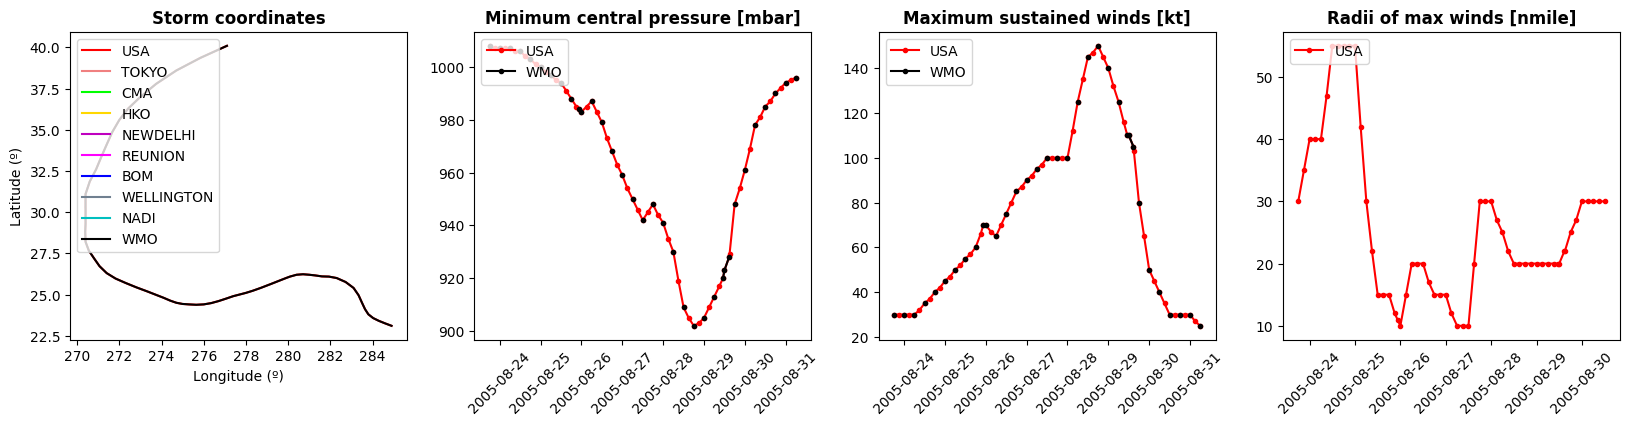

In [7]:
# storm = xr.open_dataset("outputs/ibtracs_oahu.nc").isel(storm=1)
storm_year = int(storm.season.values)

name = str(storm.name.values)[2:-1]
year = storm.time[0].dt.year.values

# plot IBTrACS data
fig = check_and_plot_track_data(storm)

In [8]:
# NOTE
# resample to 6H
# it may be necessary only for some tracks
storm = resample_storm_6h(storm)
storm["lon"] = (
    ("time"),
    np.where(storm["lon"].values < 0, storm["lon"].values + 360, storm["lon"].values),
)

/home/grupos/geocean/tausiaj/miniforge3/envs/bluemath-dev/lib/python3.12/site-packages/xarray/groupers.py:490: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


## 3. SHyTCWaves

<div class="alert-warning">
<b>Info:</b> Here SHyTCWaves runs for the defined track and in the area defined below
</div>

<style>
.alert-warning {
    background-color: #f0fff0; /* Color de fondo verdecito muy claro */
    color: #006400; /* Color del texto verde oscuro */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #98fb98; /* Borde verde claro */
}
</style>

In [10]:
# Are sourrounding storm to extract bulk parameters
extra_area = 12
area = [
    storm.lon.min().values - extra_area,
    storm.lon.max().values + extra_area,
    storm.lat.min().values - extra_area,
    storm.lat.max().values + extra_area,
]

In [27]:
t0 = time.time()

# project path
path_proj = op.join(output_path, "tc_{0}_{1}_{2}".format(itc, name, year))
if not op.isdir(path_proj):
    os.mkdir(path_proj)

tc_name = name + "_hist"
center = "WMO"

swath_resolution = 0.5
lon = np.arange(area[0], area[1], swath_resolution)
lat = np.arange(area[2], area[3], swath_resolution)

historic2shytcwaves_cluster(
    path_proj,
    tc_name,
    storm,
    center,
    lon,
    lat,
    dict_site={
        "lonpts": [360 - 88.289, 360 - 87.781, 360 - 88.237, 360 - 88.643],
        "latpts": [28.521, 29.229, 29.207, 29.579],
        "namepts": ["KIKT", "KVOA", "42040", "42354"],
        "site": "NewOrleans",
        "sectors": {0: (-90, 0), 1: (0, 90), 2: (90, 180), 3: (180, 270)},
    },
    calibration=True,
    extract_bulk=True,
)

print(f"Elapsed time: {time.time() - t0} s")

st: 29, df_seg: 28
Number of segments: 26, number of swath nodes: 6232
Merging bulk envelope... 2025-06-23 10:26:14.552736
Merging bulk envelope... 2025-06-23 10:26:20.136168
Inserting envelope spectra... 2025-06-23 10:27:51.198551
Files stored.
Elapsed time: 130.27859544754028 s


## 4. Plotting

In [1]:
import xarray as xr

In [2]:
# Load results
xds_spec = xr.open_dataset(
    # op.join(path_proj, "{0}_xds_shy_spec_NewOrleans.nc".format(tc_name))
    "outputs/tc_[11894]_KATRINA_2005/KATRINA_hist_xds_shy_spec_NewOrleans.nc"
)
xds_spec

<xarray.Dataset> Size: 17MB
Dimensions:  (freq: 38, dir: 72, point: 4, time: 198)
Coordinates:
  * freq     (freq) float64 304B 0.03 0.033 0.0363 0.0399 ... 0.8273 0.9096 1.0
  * dir      (dir) float64 576B 267.5 262.5 257.5 252.5 ... -77.5 -82.5 -87.5
  * point    (point) int64 32B 0 1 2 3
  * time     (time) datetime64[ns] 2kB 2005-08-24T06:00:00 ... 2005-09-01T11:...
Data variables:
    efth     (freq, dir, point, time) float64 17MB ...
    lon      (point) float64 32B ...
    lat      (point) float64 32B ...
    station  (point) <U5 80B ...

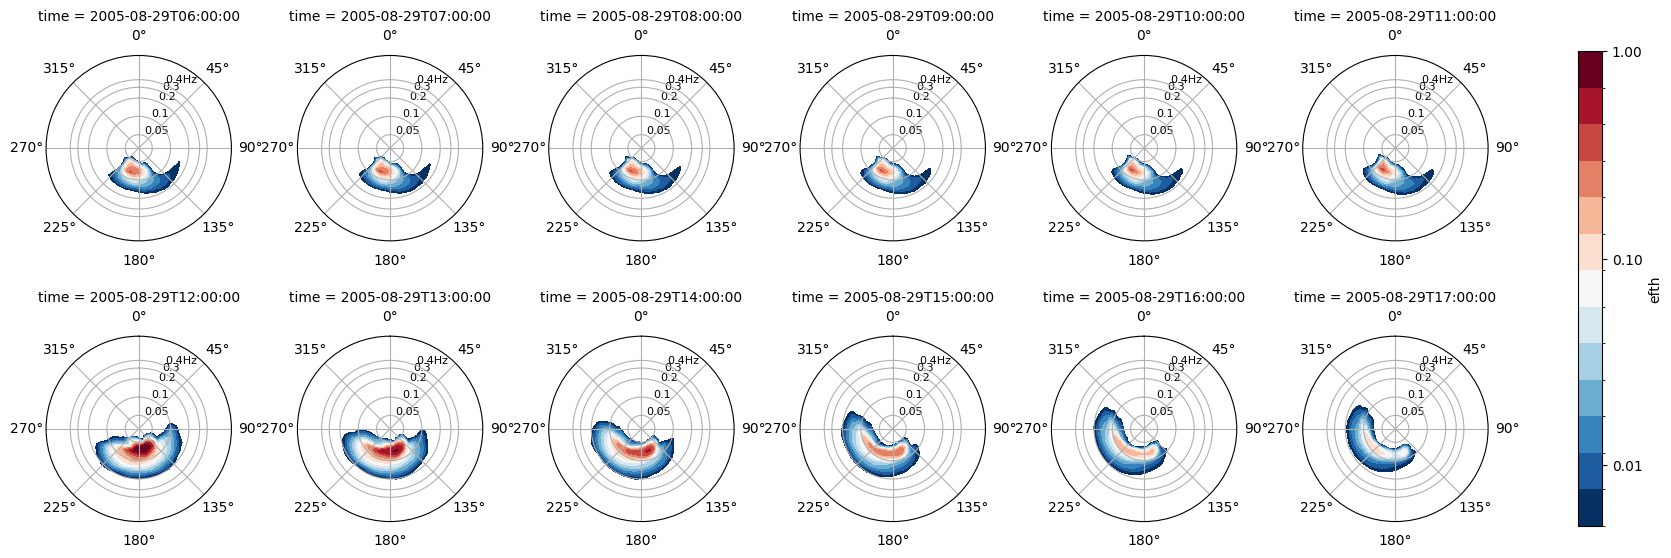

In [3]:
xds_spec.isel(point=2).efth.sel(
    time=slice("2005-08-29 06:00:00", "2005-08-29 17:00:00")
).spec.plot(col="time", col_wrap=6)

## 5. Validation

In [4]:
from bluemath_tk.downloaders.noaa.noaa_downloader import NOAADownloader

noaa_downloader = NOAADownloader(base_path_to_download="NOAA_data")
buoy_dfs = noaa_downloader.download_data(
    data_type="directional_spectra",
    load_df=True,
    buoy_id="42040",
    years=[2005],
)
buoy_dfs

(                      0.03   0.04   0.05   0.06   0.07   0.08   0.09   0.10  \
 2005-01-01 00:00:00  269.0  271.0   79.0   79.0  258.0  156.0  150.0  146.0   
 2005-01-01 01:00:00   88.0   89.0   90.0   83.0  156.0  128.0  141.0  150.0   
 2005-01-01 02:00:00   90.0  276.0   85.0   76.0  261.0  186.0  164.0  151.0   
 2005-01-01 03:00:00  277.0   86.0   76.0   95.0  114.0  113.0  137.0  153.0   
 2005-01-01 04:00:00   89.0   80.0   61.0   57.0  151.0  154.0  160.0  150.0   
 ...                    ...    ...    ...    ...    ...    ...    ...    ...   
 2005-12-31 19:00:00  265.0  246.0  137.0  183.0  187.0  252.0  321.0  247.0   
 2005-12-31 20:00:00   94.0  102.0   81.0  110.0  137.0  142.0  149.0  168.0   
 2005-12-31 21:00:00  265.0   99.0  266.0  109.0   96.0   45.0   77.0  241.0   
 2005-12-31 22:00:00  277.0   97.0   89.0   93.0   90.0   96.0   28.0   66.0   
 2005-12-31 23:00:00  274.0  281.0  103.0   91.0   95.0   55.0   46.0   67.0   
 
                       0.11   0.12  ..

In [6]:
from typing import Tuple

import numpy as np


def calculate_directional_spectrum(
    C11: np.ndarray,
    freq: np.ndarray,
    alpha1: np.ndarray,
    alpha2: np.ndarray,
    r1: np.ndarray,
    r2: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Calculate normalized directional wave spectrum.

    Parameters
    ----------
    C11 : np.ndarray
        Wave energy spectrum
    freq : np.ndarray
        Frequency array
    alpha1 : np.ndarray
        Primary direction array
    alpha2 : np.ndarray
        Secondary direction array
    r1 : np.ndarray
        Primary spreading parameter array
    r2 : np.ndarray
        Secondary spreading parameter array

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        Tuple containing (E, freq_mesh, angle_mesh)
    """

    angles = np.linspace(0, 2 * np.pi, 360)
    angle_mesh, freq_mesh = np.meshgrid(angles, freq)
    alpha1_rad = np.deg2rad(alpha1)
    alpha2_rad = np.deg2rad(alpha2)
    r1 = np.array(r1) / 100
    r2 = np.array(r2) / 100
    E = np.zeros((len(freq), len(angles)))

    for i in range(len(freq)):
        D = (1 / np.pi) * (
            0.5
            + r1[i] * np.cos(angles - alpha1_rad[i])
            + r2[i] * np.cos(2 * (angles - alpha2_rad[i]))
        )
        D = D / np.trapz(D, angles)
        D[D < 0] = 0
        E[i, :] = C11[i] * D

    return E, freq_mesh, angle_mesh

In [18]:
# Example usage
buoy_id = "42040"
date_str = "2005-08-29 12:00"  # For specific date plot

# For specific date plot
alpha1, alpha2, r1, r2, c11 = (
    direc_df_elem.loc[date_str].values for direc_df_elem in buoy_dfs
)
freqs = buoy_dfs[0].columns.values

E, freq_mesh, angle_mesh = calculate_directional_spectrum(
    c11, freqs, alpha1, alpha2, r1, r2
)

In [8]:
E.shape, freq_mesh[:, 0].shape, angle_mesh[0, :].shape

((33, 360), (33,), (360,))

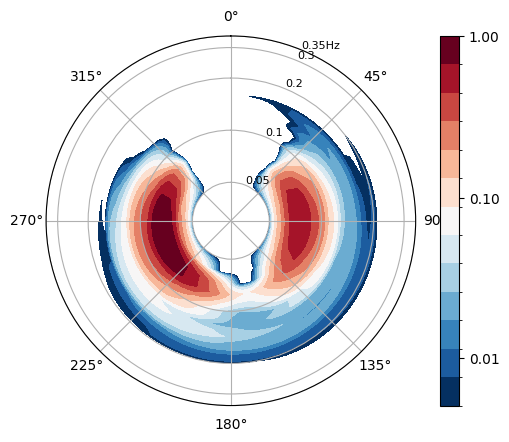

In [23]:
xr.DataArray(
    data=E,
    coords=dict(
        freq=freq_mesh[:, 0],
        dir=angle_mesh[0, :] * 180 / np.pi,
    ),
    dims=["freq", "dir"],
).spec.plot()

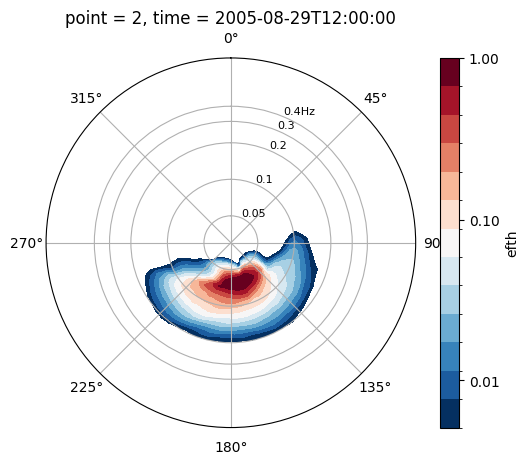

In [24]:
xds_spec.isel(point=2).efth.sel(time=date_str, method="nearest").spec.plot()